In [1]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"
# отключение предупреждения

#os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

In [2]:
import os 
import pathlib 
import numpy as np
from glob import glob

import shutil

import matplotlib.pyplot as plt
from torchsummary import summary


In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("работаем на устройстве: ", DEVICE)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

True
работаем на устройстве:  cuda
Версия torch:            2.0.1+cu118
версия  cuDNN:           8700


In [4]:
# Текущее положение
path_1 = os.getcwd()
path_1

'C:\\Users\\drug1\\Anaconda\\films'

In [5]:
# Пути к директориям с данными

train_dir = os.path.join(path_1, 'data\\train\\')
test_dir = os.path.join(path_1, 'data\\test\\')
val_dir = os.path.join(path_1, 'data\\val\\')

In [6]:
# Расположение файла для кодировки слов
path_vocab = 'C:\\Users\\drug1\\Anaconda\\Keras\\films\\imdb.vocab'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms


In [8]:

# Определение класса модели
class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)  # Добавление слоя Dropout
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm1(embedded)
        output, _ = self.lstm2(output)
        output = self.dropout(output)  # Применение Dropout к выходу LSTM
        output = self.fc(output[:, -1, :])  # Используется только последний выход LSTM
        return output

In [9]:
####
####     КРОС ВАЛИДАЦИЯ
####


def train_model_cross(model, train_data_tensor, train_labels_tensor, k_folds = 5, num_epochs=5, save_model_path = 'model_1.pth'):
   
    X = train_data_tensor
    y = train_labels_tensor

    # Создание объекта K-fold cross-validation
    kfold = KFold(n_splits=k_folds)

    # Обучение модели
    best_val_accuracy = 0  # Инициализация переменной для отслеживания лучшего значения функции потерь на валидационном наборе

    # Итерация по фолдам
    for fold, (train_indices, val_indices) in enumerate(kfold.split(X)):


        # Разделение данных на тренировочный и валидационный наборы
        train_X, train_y = X[train_indices], y[train_indices]
        val_X, val_y = X[val_indices], y[val_indices]

        # Создание DataLoader для тренировочного и валидационного наборов
        train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
        val_dataset = torch.utils.data.TensorDataset(val_X, val_y)



        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Обучение модели
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            total_correct = 0
            total_samples = 0

            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            train_accuracy = total_correct / total_samples
            train_loss = total_loss / len(train_loader)

            # Валидация модели
            val_loss = float('inf')
            model.eval()
            with torch.no_grad():
                total_val_loss = 0
                total_val_correct = 0
                total_val_samples = 0

                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, 1)
                    total_val_correct += (predicted == labels).sum().item()
                    total_val_samples += labels.size(0)

                    total_val_loss += val_loss.item()

                val_accuracy = total_val_correct / total_val_samples
                val_loss = total_val_loss / len(val_loader)

            print(f"Fold {fold+1} | Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

             # Проверка, является ли текущая модель лучшей
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                # Сохранение модели
                torch.save(model.state_dict(), save_model_path)

In [10]:
def train_model(model, train_loader, val_loader, num_epochs=5, save_model_path = 'model_1.pth'):
    # Обучение модели
    train_losses = []  # Список для сохранения значений функции потерь на тренировочном наборе
    val_losses = []  # Список для сохранения значений функции потерь на валидационном наборе
    train_accuracies = []  # Список для сохранения значений точности на тренировочном наборе
    val_accuracies = []  # Список для сохранения значений точности на валидационном наборе

    
    best_val_accuracy = 0  # Инициализация переменной для отслеживания лучшего значения функции потерь на валидационном наборе

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_accuracy = total_correct / total_samples
        train_loss = total_loss / len(train_loader)


        # Валидация модели
        val_loss = float('inf')
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            total_val_correct = 0
            total_val_samples = 0

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val_correct += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

                total_val_loss += val_loss.item()



            val_accuracy = total_val_correct / total_val_samples
            val_loss = total_val_loss / len(val_loader)

            ###########################################
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)    
            ###############################################
            
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

         # Проверка, является ли текущая модель лучшей
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Сохранение модели
            torch.save(model.state_dict(), save_model_path)
            
    # Построение графика потерь
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Построение графика точности
    plt.figure()
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()
        

In [11]:
# Тестировани е модели

def evaluation_model(test_loader):
    # Оценка модели
    model.eval()
    with torch.no_grad():
        total_test_correct = 0
        total_test_samples = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total_test_correct += (predicted == labels).sum().item()
            total_test_samples += labels.size(0)

        test_accuracy = total_test_correct / total_test_samples
    text = f" точность: {test_accuracy:.4f}"
    return text  

In [12]:

# Загрузка данных из файлов

train_data_tensor = torch.load('train_data3.pt')
train_labels_tensor = torch.load('train_labels3.pt')

test_data_tensor = torch.load('test_data4.pt')
test_labels_tensor = torch.load('test_labels4.pt')

In [13]:
# Датасеты
train_dataset = torch.utils.data.TensorDataset(train_data_tensor.clone().detach(), train_labels_tensor.clone().detach())

test_dataset = torch.utils.data.TensorDataset(test_data_tensor.clone().detach(), test_labels_tensor.clone().detach())


In [14]:
# Параметры модели и тренировки
input_size = 40000  # Предполагаемый размер словаря (число уникальных слов)

hidden_size = 128
num_classes = 8  # классы отзывов
num_epochs = 5
batch_size = 48
learning_rate = 0.001
weight_decay=0.01
len_text = 500  # длина текста (клоичество слов) используемая для оценки 


# Определение числа фолдов
k_folds = 5

In [15]:
learning_rate = 0.001
batch_size = 128

In [16]:
# Создание итераторов для загрузки данных

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)





test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
# Инициализация модели


model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

model.to(device)

SentimentClassifier(
  (embedding): Embedding(40000, 128)
  (lstm1): LSTM(128, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [18]:
len(test_data_tensor)

50000

In [19]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 






Epoch 1/20 | Train Loss: 2.0650 | Train Accuracy: 0.1499 | Val Loss: 2.0309 | Val Accuracy: 0.2067
Epoch 2/20 | Train Loss: 2.0071 | Train Accuracy: 0.1860 | Val Loss: 2.0592 | Val Accuracy: 0.1979
Epoch 3/20 | Train Loss: 1.9109 | Train Accuracy: 0.2178 | Val Loss: 1.6566 | Val Accuracy: 0.3351
Epoch 4/20 | Train Loss: 1.6717 | Train Accuracy: 0.3045 | Val Loss: 1.5249 | Val Accuracy: 0.3926
Epoch 5/20 | Train Loss: 1.5618 | Train Accuracy: 0.3452 | Val Loss: 1.4856 | Val Accuracy: 0.3906
Epoch 6/20 | Train Loss: 1.4766 | Train Accuracy: 0.3777 | Val Loss: 1.4113 | Val Accuracy: 0.4171
Epoch 7/20 | Train Loss: 1.4010 | Train Accuracy: 0.4079 | Val Loss: 1.3411 | Val Accuracy: 0.4456
Epoch 8/20 | Train Loss: 1.3321 | Train Accuracy: 0.4390 | Val Loss: 1.2873 | Val Accuracy: 0.4739
Epoch 9/20 | Train Loss: 1.2626 | Train Accuracy: 0.4720 | Val Loss: 1.1963 | Val Accuracy: 0.5206
Epoch 10/20 | Train Loss: 1.1945 | Train Accuracy: 0.5101 | Val Loss: 1.1381 | Val Accuracy: 0.5442
Epoch 11/

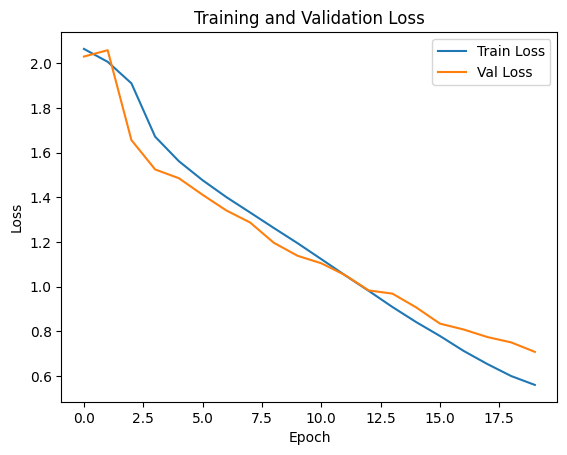

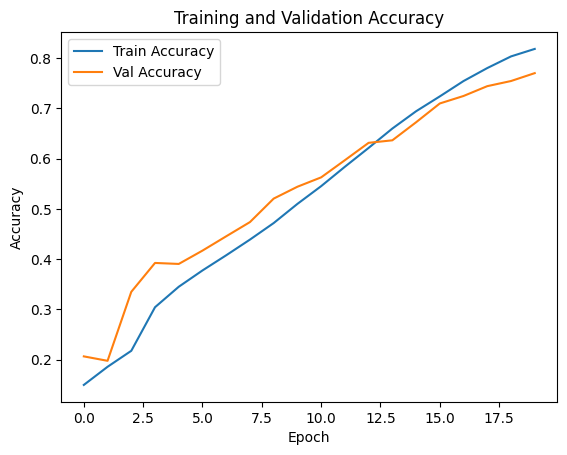

train -   точность: 0.8492
test -   точность: 0.7703
train -   точность: 0.8492
test -   точность: 0.7703


In [23]:
hidden_size = 64

model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_1.pth'))


# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 




#model.to(device)



train_model(model, train_loader, test_loader, num_epochs=20, save_model_path = 'model_1.pth')

# Сохранение модели
torch.save(model.state_dict(), 'model_1_1.pth')

print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

model.load_state_dict(torch.load('model_1.pth'))
model.to(device)
print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

Epoch 1/20 | Train Loss: 1.9952 | Train Accuracy: 0.1886 | Val Loss: 1.9314 | Val Accuracy: 0.2344
Epoch 2/20 | Train Loss: 1.9114 | Train Accuracy: 0.2220 | Val Loss: 1.8537 | Val Accuracy: 0.2617
Epoch 3/20 | Train Loss: 1.8843 | Train Accuracy: 0.2335 | Val Loss: 1.7349 | Val Accuracy: 0.3409
Epoch 4/20 | Train Loss: 1.7693 | Train Accuracy: 0.2636 | Val Loss: 1.6307 | Val Accuracy: 0.3237
Epoch 5/20 | Train Loss: 1.6904 | Train Accuracy: 0.2931 | Val Loss: 1.6066 | Val Accuracy: 0.3439
Epoch 6/20 | Train Loss: 1.5823 | Train Accuracy: 0.3304 | Val Loss: 1.4725 | Val Accuracy: 0.3995
Epoch 7/20 | Train Loss: 1.4817 | Train Accuracy: 0.3733 | Val Loss: 1.3772 | Val Accuracy: 0.4410
Epoch 8/20 | Train Loss: 1.3947 | Train Accuracy: 0.4103 | Val Loss: 1.3082 | Val Accuracy: 0.4677
Epoch 9/20 | Train Loss: 1.3099 | Train Accuracy: 0.4516 | Val Loss: 1.3161 | Val Accuracy: 0.4517
Epoch 10/20 | Train Loss: 1.2190 | Train Accuracy: 0.4993 | Val Loss: 1.2026 | Val Accuracy: 0.5178
Epoch 11/

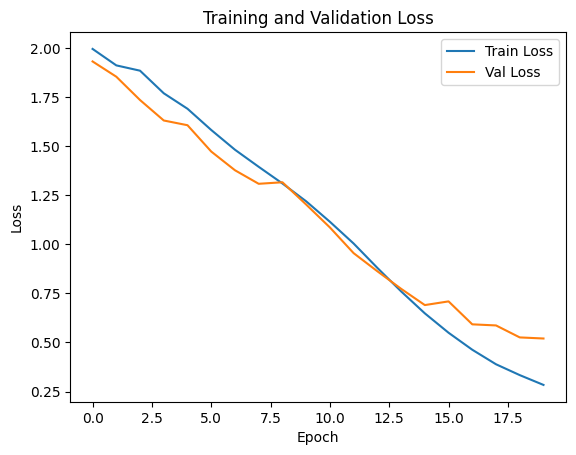

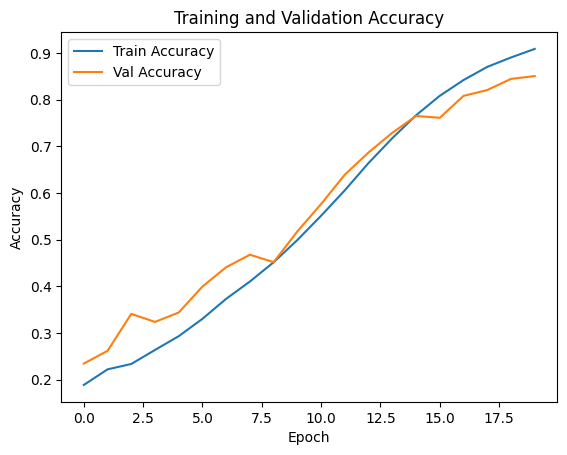

train -   точность: 0.9393
test -   точность: 0.8507
train -   точность: 0.9393
test -   точность: 0.8507


In [24]:
hidden_size = 128

model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_2.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 



model.to(device)



train_model(model, train_loader, test_loader, num_epochs=20, save_model_path = 'model_2.pth')

# Сохранение модели
torch.save(model.state_dict(), 'model_2_1.pth')


print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

model.load_state_dict(torch.load('model_2.pth'))
model.to(device)
print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

Epoch 1/20 | Train Loss: 2.0053 | Train Accuracy: 0.1866 | Val Loss: 1.8251 | Val Accuracy: 0.3087
Epoch 2/20 | Train Loss: 1.8166 | Train Accuracy: 0.2602 | Val Loss: 1.6226 | Val Accuracy: 0.3709
Epoch 3/20 | Train Loss: 1.6418 | Train Accuracy: 0.3268 | Val Loss: 1.4766 | Val Accuracy: 0.4126
Epoch 4/20 | Train Loss: 1.4593 | Train Accuracy: 0.4040 | Val Loss: 1.2840 | Val Accuracy: 0.5072
Epoch 5/20 | Train Loss: 1.2333 | Train Accuracy: 0.5148 | Val Loss: 1.0171 | Val Accuracy: 0.6190
Epoch 6/20 | Train Loss: 0.9443 | Train Accuracy: 0.6421 | Val Loss: 0.7792 | Val Accuracy: 0.7279
Epoch 7/20 | Train Loss: 0.6588 | Train Accuracy: 0.7612 | Val Loss: 0.5619 | Val Accuracy: 0.8159
Epoch 8/20 | Train Loss: 0.4211 | Train Accuracy: 0.8536 | Val Loss: 0.4374 | Val Accuracy: 0.8619
Epoch 9/20 | Train Loss: 0.2738 | Train Accuracy: 0.9081 | Val Loss: 0.4030 | Val Accuracy: 0.8834
Epoch 10/20 | Train Loss: 0.1801 | Train Accuracy: 0.9404 | Val Loss: 0.3898 | Val Accuracy: 0.8950
Epoch 11/

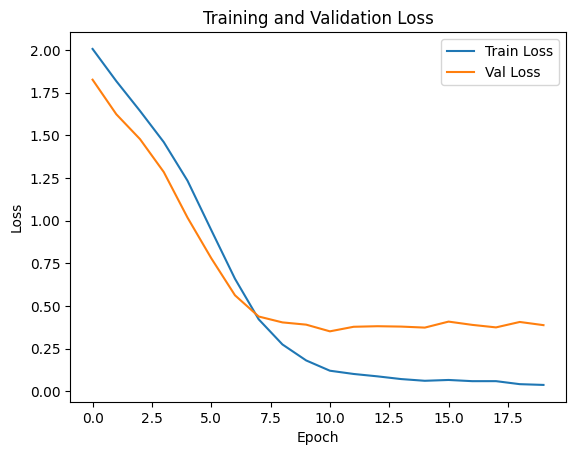

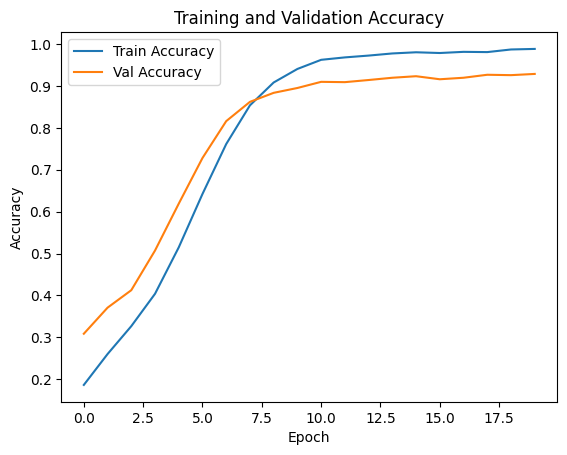

train -   точность: 0.9941
test -   точность: 0.9285
train -   точность: 0.9941
test -   точность: 0.9285


In [25]:
hidden_size = 256

model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_3.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 



model.to(device)



train_model(model, train_loader, test_loader, num_epochs=20, save_model_path = 'model_3.pth')

# Сохранение модели
torch.save(model.state_dict(), 'model_3_1.pth')


print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

model.load_state_dict(torch.load('model_3.pth'))
model.to(device)
print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

Epoch 1/20 | Train Loss: 1.9999 | Train Accuracy: 0.1870 | Val Loss: 1.9395 | Val Accuracy: 0.2468
Epoch 2/20 | Train Loss: 1.8380 | Train Accuracy: 0.2530 | Val Loss: 1.6762 | Val Accuracy: 0.3374
Epoch 3/20 | Train Loss: 1.6408 | Train Accuracy: 0.3215 | Val Loss: 1.5162 | Val Accuracy: 0.3866
Epoch 4/20 | Train Loss: 1.4937 | Train Accuracy: 0.3770 | Val Loss: 1.3851 | Val Accuracy: 0.4393
Epoch 5/20 | Train Loss: 1.3036 | Train Accuracy: 0.4702 | Val Loss: 1.1323 | Val Accuracy: 0.5652
Epoch 6/20 | Train Loss: 1.0763 | Train Accuracy: 0.5810 | Val Loss: 0.9033 | Val Accuracy: 0.6661
Epoch 7/20 | Train Loss: 0.8192 | Train Accuracy: 0.6900 | Val Loss: 0.7586 | Val Accuracy: 0.7235
Epoch 8/20 | Train Loss: 0.5788 | Train Accuracy: 0.7936 | Val Loss: 0.5467 | Val Accuracy: 0.8188
Epoch 9/20 | Train Loss: 0.3952 | Train Accuracy: 0.8629 | Val Loss: 0.4739 | Val Accuracy: 0.8475
Epoch 10/20 | Train Loss: 0.2707 | Train Accuracy: 0.9102 | Val Loss: 0.3963 | Val Accuracy: 0.8822
Epoch 11/

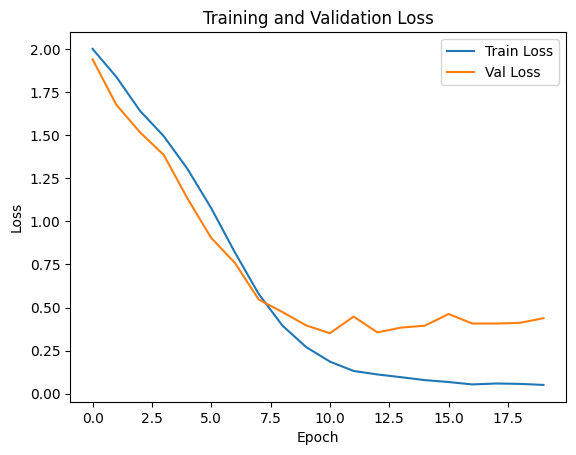

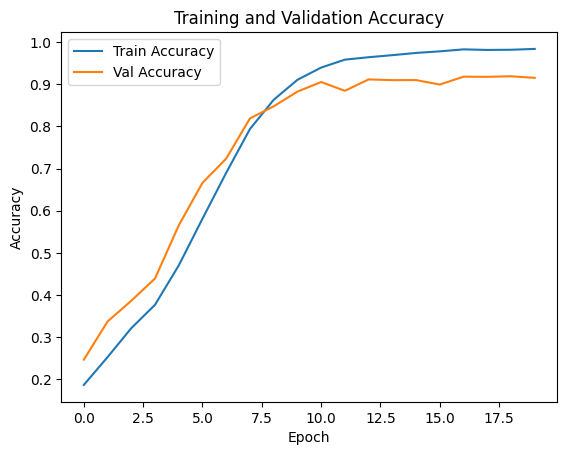

train -   точность: 0.9893
test -   точность: 0.9148
train -   точность: 0.9906
test -   точность: 0.9186


In [29]:
hidden_size = 200

model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_4.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 



model.to(device)



train_model(model, train_loader, test_loader, num_epochs=20, save_model_path = 'model_4.pth')

# Сохранение модели
torch.save(model.state_dict(), 'model_4_1.pth')


print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

model.load_state_dict(torch.load('model_4.pth'))
model.to(device)
print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

In [36]:
hidden_size = 64

model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)

# Загрузка сохраненной модели

model.load_state_dict(torch.load('model_cross_1.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) 

#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

model.to(device)



train_model_cross(model, train_data_tensor, train_labels_tensor, k_folds = 5, num_epochs=5, save_model_path = 'model_cross_1.pth')

print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))
# Загрузка сохраненной модели

model.load_state_dict(torch.load('model_cross_1.pth'))
model.to(device)
print('train - ', evaluation_model(train_loader))

print('test - ', evaluation_model(test_loader))

Fold 1 | Epoch 1/5 | Train Loss: 0.3247 | Train Accuracy: 0.8998 | Val Loss: 1.0555 | Val Accuracy: 0.6159
Fold 1 | Epoch 2/5 | Train Loss: 0.2757 | Train Accuracy: 0.9162 | Val Loss: 1.5838 | Val Accuracy: 0.4840
Fold 1 | Epoch 3/5 | Train Loss: 0.2573 | Train Accuracy: 0.9229 | Val Loss: 1.8434 | Val Accuracy: 0.4440
Fold 1 | Epoch 4/5 | Train Loss: 0.2427 | Train Accuracy: 0.9264 | Val Loss: 2.5797 | Val Accuracy: 0.3163
Fold 1 | Epoch 5/5 | Train Loss: 0.2344 | Train Accuracy: 0.9300 | Val Loss: 2.5210 | Val Accuracy: 0.3076
Fold 2 | Epoch 1/5 | Train Loss: 0.2767 | Train Accuracy: 0.9187 | Val Loss: 1.0111 | Val Accuracy: 0.6168
Fold 2 | Epoch 2/5 | Train Loss: 0.2218 | Train Accuracy: 0.9351 | Val Loss: 1.6561 | Val Accuracy: 0.4995
Fold 2 | Epoch 3/5 | Train Loss: 0.2015 | Train Accuracy: 0.9427 | Val Loss: 1.7366 | Val Accuracy: 0.4975
Fold 2 | Epoch 4/5 | Train Loss: 0.1826 | Train Accuracy: 0.9484 | Val Loss: 1.7698 | Val Accuracy: 0.4831
Fold 2 | Epoch 5/5 | Train Loss: 0.17

In [33]:
hidden_size = 128

#device="cpu"
model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)


# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_cross_2.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)  
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

model.to(device)



train_model_cross(model, train_data_tensor, train_labels_tensor, k_folds = 5, num_epochs=5, save_model_path = 'model_cross_2.pth')

print('train - ', evaluation_model(train_loader))
print('test - ', evaluation_model(test_loader))
# Загрузка сохраненной модели

model.load_state_dict(torch.load('model_cross_2.pth'))
model.to(device)

print('train - ', evaluation_model(train_loader))
print('test - ', evaluation_model(test_loader))

Fold 1 | Epoch 1/5 | Train Loss: 1.9345 | Train Accuracy: 0.1680 | Val Loss: 5.5657 | Val Accuracy: 0.0283
Fold 1 | Epoch 2/5 | Train Loss: 1.7872 | Train Accuracy: 0.2484 | Val Loss: 4.4456 | Val Accuracy: 0.0496
Fold 1 | Epoch 3/5 | Train Loss: 1.5700 | Train Accuracy: 0.3311 | Val Loss: 6.3884 | Val Accuracy: 0.0251
Fold 1 | Epoch 4/5 | Train Loss: 1.4275 | Train Accuracy: 0.3945 | Val Loss: 5.8911 | Val Accuracy: 0.0248
Fold 1 | Epoch 5/5 | Train Loss: 1.3081 | Train Accuracy: 0.4461 | Val Loss: 5.6869 | Val Accuracy: 0.0548
Fold 2 | Epoch 1/5 | Train Loss: 1.2630 | Train Accuracy: 0.4613 | Val Loss: 3.4674 | Val Accuracy: 0.0485
Fold 2 | Epoch 2/5 | Train Loss: 1.1276 | Train Accuracy: 0.5175 | Val Loss: 3.8681 | Val Accuracy: 0.0618
Fold 2 | Epoch 3/5 | Train Loss: 1.0134 | Train Accuracy: 0.5780 | Val Loss: 4.0718 | Val Accuracy: 0.0801
Fold 2 | Epoch 4/5 | Train Loss: 0.8926 | Train Accuracy: 0.6407 | Val Loss: 4.2371 | Val Accuracy: 0.0781
Fold 2 | Epoch 5/5 | Train Loss: 0.75

In [34]:
hidden_size = 256

#device="cpu"
model = SentimentClassifier(input_size, hidden_size, num_classes).to(device)


# Загрузка сохраненной модели

#model.load_state_dict(torch.load('model_cross_3.pth'))

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate) 
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate) 
#optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)  
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

model.to(device)



train_model_cross(model, train_data_tensor, train_labels_tensor, k_folds = 5, num_epochs=5, save_model_path = 'model_cross_3.pth')

print('train - ', evaluation_model(train_loader))
print('test - ', evaluation_model(test_loader))
# Загрузка сохраненной модели

model.load_state_dict(torch.load('model_cross_3.pth'))
model.to(device)

print('train - ', evaluation_model(train_loader))
print('test - ', evaluation_model(test_loader))

Fold 1 | Epoch 1/5 | Train Loss: 1.9176 | Train Accuracy: 0.1799 | Val Loss: 5.3685 | Val Accuracy: 0.0130
Fold 1 | Epoch 2/5 | Train Loss: 1.5894 | Train Accuracy: 0.3270 | Val Loss: 5.3270 | Val Accuracy: 0.0391
Fold 1 | Epoch 3/5 | Train Loss: 1.3834 | Train Accuracy: 0.4144 | Val Loss: 5.6825 | Val Accuracy: 0.0374
Fold 1 | Epoch 4/5 | Train Loss: 1.1991 | Train Accuracy: 0.4960 | Val Loss: 6.9637 | Val Accuracy: 0.0290
Fold 1 | Epoch 5/5 | Train Loss: 0.9937 | Train Accuracy: 0.5954 | Val Loss: 7.0737 | Val Accuracy: 0.0362
Fold 2 | Epoch 1/5 | Train Loss: 0.9868 | Train Accuracy: 0.6015 | Val Loss: 2.8271 | Val Accuracy: 0.1311
Fold 2 | Epoch 2/5 | Train Loss: 0.7595 | Train Accuracy: 0.7034 | Val Loss: 2.9643 | Val Accuracy: 0.1496
Fold 2 | Epoch 3/5 | Train Loss: 0.5661 | Train Accuracy: 0.7914 | Val Loss: 3.4421 | Val Accuracy: 0.1521
Fold 2 | Epoch 4/5 | Train Loss: 0.4081 | Train Accuracy: 0.8564 | Val Loss: 3.6786 | Val Accuracy: 0.1748
Fold 2 | Epoch 5/5 | Train Loss: 0.28